# Sentiment Analysis Using Tensorflow GRU with Attention Layer

## Imports

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.compat.v1.keras.layers import CuDNNGRU, Embedding, Dropout,Dense, Bidirectional, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop, Adamax , Adam

from attention.layers import AttentionLayer
import tensorflow as tf
from tensorflow.python.client import device_lib

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #This is for multiple print statements per cell

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Confirm GPU processing available

In [2]:
value = tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)
print ('***If TF can access GPU: ***\n\n',value) # MUST RETURN True IF IT CAN!!

print()
value = tf.config.list_physical_devices('GPU')
print(value)

print()
print(device_lib.list_local_devices())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
***If TF can access GPU: ***

 True

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2281037819239436084
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17743577602626879576
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 731266770842073670
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1259942707
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3986183530100872125
physical_device_desc: "device: 0, name: GeForce MX150, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


## Getting data

In [3]:
df = pd.read_csv('consolidated_tweet_data-cleaned-stemmed-lemmatized.csv', sep='\t')
df

,sentiment,text
0,negative,oh no it fade away again
1,positive,bunnylak will kill me but i cant stop listen t...
2,negative,last day in cali partyin for the last time wit...
3,negative,is have a major soar throat
4,positive,my last day a 12 year old
...,...,...
1611536,negative,twisuz yeah and how did thi happen i wa updat ...
1611537,negative,smittygoali im sorri about your dog
1611538,negative,posipat im alreadi there i wish you were here
1611539,negative,is think in 12 hour ill be at the airport thi ...


In [4]:
# How much of Dataset to be used
frac = 0.5
# sample and shuffle the dataset according to the fraction choise in the line above
df = df.sample(frac=frac).reset_index(drop=True)
df

,sentiment,text
0,positive,right time to finish my brew and get to bed re...
1,negative,so i had a dream last night i rememb a sign wh...
2,positive,feed my lost addict
3,negative,go to ikea and to and art fair sergey in ohio ...
4,negative,im tri to finish my work not help with a tooth...
...,...,...
805765,negative,gata cu sarbatoril back to workschool whatev
805766,negative,haha im go crazi with updat but honestli idc m...
805767,positive,i heart kri allen got ta love my arkansa boy t...
805768,positive,xxjessica94xx hey what up my name is caleb and...


## Tokenization for training

In [5]:
vocabulary_size = 8000

In [6]:
tokenizer = Tokenizer(num_words=vocabulary_size, split=" ", oov_token='<OOV>')
tokenizer.fit_on_texts(df['text'].values)

In [7]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         120,   47,    3,  238,    7, 3779,    8,   26,    3,  151,  215,
          11,  440,  102,   24,    7, 1903],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   19,    2,   68,    5,  391,   96,   74,    2,  441,    5,
         560,  389, 2284,  516,   17,  200,    3,   26,    5,  310,    2,
          49,    1,   50,    4,  560,  295],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0, 1244,    7,  252,  929],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   20,    3, 3540,    8,    3,  

## Model, Training and Testing

### Creating the model

In [8]:
model = Sequential()
model.add(Embedding(vocabulary_size, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(Bidirectional(CuDNNGRU(256, return_sequences=True)))
# model.add(Dropout(0.3))
# model.add(Bidirectional(CuDNNGRU(256, return_sequences=True)))
model.add(AttentionLayer(name='attention'))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid'))

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 39, 256)           2560000   
_________________________________________________________________
dropout (Dropout)            (None, 39, 256)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 39, 512)           789504    
_________________________________________________________________
attention (AttentionLayer)   (None, 512)               263168    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense (Dense)                (None, 2)                 1026      
Total params: 3,615,746
Trainable params: 3,614,722
Non-trainable params: 1,024
__________________________________________

### Training the model

In [10]:
y = pd.get_dummies(df['sentiment']).values
[print(df['sentiment'][i], y[i]) for i in range(0,5)]

positive [0 1]
negative [1 0]
positive [0 1]
negative [1 0]
negative [1 0]


[None, None, None, None, None]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
batch_size = 32
epochs = 6
import time
from datetime import datetime
datetime = str(datetime.now())
csv_logger = tf.keras.callbacks.CSVLogger('training'+datetime+'.log')
start = time.time()
print("started at:")
print(start)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[csv_logger])
end = time.time()
elapsed = end - start
print(elapsed/60," minutes")

started at:
1586162902.1906009
Train on 644616 samples
Epoch 1/6
644616/644616 - 779s - loss: 0.4355 - accuracy: 0.7980
Epoch 2/6
644616/644616 - 768s - loss: 0.3932 - accuracy: 0.8226
Epoch 3/6
644616/644616 - 768s - loss: 0.3741 - accuracy: 0.8335
Epoch 4/6
644616/644616 - 747s - loss: 0.3610 - accuracy: 0.8410
Epoch 5/6
644616/644616 - 749s - loss: 0.3538 - accuracy: 0.8449
Epoch 6/6
644616/644616 - 761s - loss: 0.3502 - accuracy: 0.8471
76.20068103075027  minutes


Plotting training history

Text(0.5, 1.0, 'Model accuracy')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epoch')

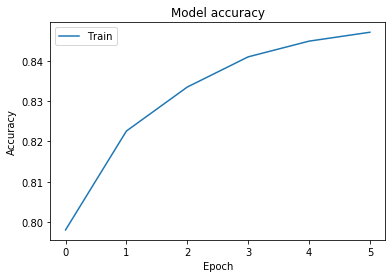

Text(0.5, 1.0, 'Model loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

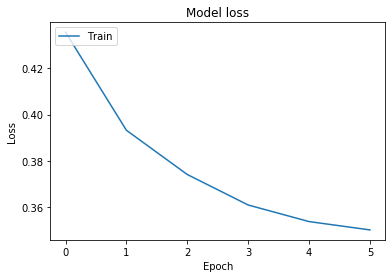

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


### Testing the model

In [14]:
predictions = model.predict(X_test)
[print(df['text'][i], predictions[i], y_test[i]) for i in range(0, 5)]

right time to finish my brew and get to bed readi for beach tomorrow with my geek  [0.06686898 0.93163425] [0 1]
so i had a dream last night i rememb a sign which clearli told me where to get a job i cant remem what the sign said  [0.98804873 0.01186629] [1 0]
feed my lost addict  [0.02429181 0.97572553] [0 1]
go to ikea and to and art fair sergey in ohio and i miss him  [0.29749808 0.70121336] [0 1]
im tri to finish my work not help with a toothach though  [0.83649176 0.16327028] [1 0]


[None, None, None, None, None]

In [15]:
accurate_prediction_count, inaccurate_prediction_count = 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==np.argmax(y_test[i]):
        accurate_prediction_count += 1
    else:
        inaccurate_prediction_count += 1

total_predictions = accurate_prediction_count + inaccurate_prediction_count
print('Number of predictions: ', total_predictions)
print('Number of accurate predictions: ', accurate_prediction_count)
print('Number of false predictions: ', inaccurate_prediction_count)    
print('Accuracy: ', accurate_prediction_count/total_predictions)

Number of predictions:  161154
Number of accurate predictions:  132569
Number of false predictions:  28585
Accuracy:  0.8226230810280849


### Saving the trained model

name of the file

In [16]:
name = 'sentiment-analysis-trained-model'

In [18]:
from datetime import datetime
dateTimeObj = datetime.now()
date = str(dateTimeObj.date())
time = str(dateTimeObj.time())
timestamp = date+time
punctuation = ['-',':','.']
for sign in punctuation:
    timestamp = timestamp.replace(sign,'')
print(timestamp)

20200406133655988053


In [19]:
model.save(name+timestamp+'.h5')